angles_straight:  (11138, 4)
angles_recover:  (1025, 4)
angles:  (12163, 4)


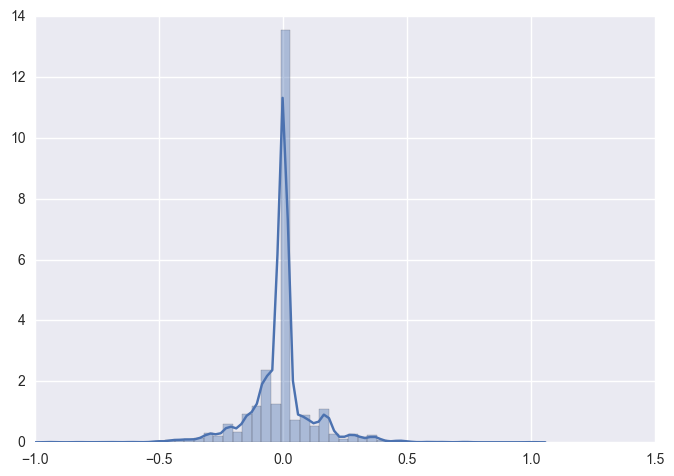

In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os
import seaborn as sns
%matplotlib inline

straight = "./data/"
recover = "./data/recover/"
log = "driving_log.csv"


data = pd.read_csv(straight + log)
angles_straight = data[["center", "left", "right", "steering"]]
print("angles_straight: ", angles_straight.shape)

data = pd.read_csv(recover + log)
angles_recover = data[["center", "left", "right", "steering"]]
print("angles_recover: ", angles_recover.shape)
angles = pd.concat([angles_straight, angles_recover])
print("angles: ", angles.shape)
#for filename in os.listdir("./data/IMG"):
#    if filename.startswith('center'):
#        img = cv2.imread("./data/IMG/" + filename)
#        center_img.append(img)
sns.set(color_codes=True)       
sns.distplot(angles.steering.values)


In [2]:
angles_0 = angles[angles.steering == 0]
angles_1 = angles[angles.steering != 0]
print(angles_0.shape, angles_1.shape)

(6041, 4) (6122, 4)


In [3]:
angles_0_sampled = angles_0.sample(frac=0.2, random_state=0)
angles_1_sampled = angles_1.sample(frac=1, random_state=0)

(7330, 4)


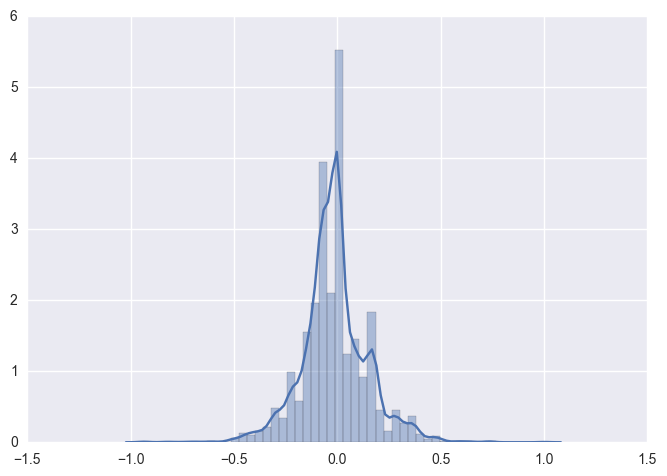

In [4]:
angles_sampled = pd.concat([angles_0_sampled, angles_1_sampled])
print(angles_sampled.shape)
sns.distplot(angles_sampled.steering.values)

In [5]:
file_list_center = angles_sampled[["center"]].values
angle_list_center = angles_sampled[["steering"]].values

file_list_left = angles_sampled[["left"]].values
angle_list_left = angle_list_center + 0.25

file_list_right = angles_sampled[["right"]].values
angle_list_right = angle_list_center - 0.25

file_list = np.concatenate((file_list_center, file_list_left, file_list_right))
angle_list = np.concatenate((angle_list_center, angle_list_left, angle_list_right))

file_list = np.squeeze(file_list)
angle_list = np.squeeze(angle_list)
print(file_list.shape, angle_list.shape)

(21990,) (21990,)


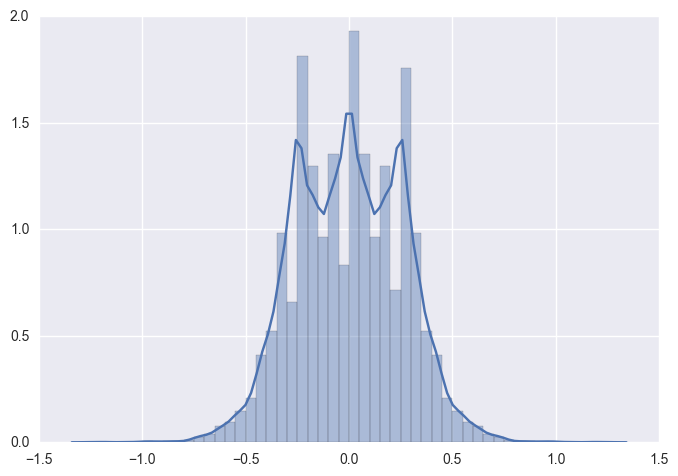

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train = []
X_train_flip = [] 
angle_list_flip = -1 * angle_list
for filename in file_list:
    if(filename[0] == ' '):
        filename = filename[1:]
    imgBGR = cv2.imread(filename) 
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    X_train.append(imgRGB)
    X_train_flip.append(np.fliplr(imgRGB))

X_train = np.concatenate((X_train, X_train_flip))
angle_list = np.concatenate((angle_list, angle_list_flip))

X_train, angle_list = shuffle(X_train, angle_list, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, angle_list, test_size=.2, random_state=0)
sns.distplot(angle_list)

In [7]:
X_train.shape
y_train.shape

(35184,)

In [ ]:
np.save("./X_train", X_train)
np.save("./y_train", y_train)
np.save("./X_val", X_val)
np.save("./y_val", y_val)

In [1]:
import cv2
import json
import random
import math
import argparse
import time
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution2D, Conv2D, ELU, Flatten, Dense, Dropout, Lambda, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
def get_model(time_len=1):
  ch, row, col = 3, 160, 320  # camera format
  shape = (row, col, ch)

  model = Sequential()
  model.add(Lambda(lambda x: x/127.5 -1., input_shape=shape, output_shape=shape))
  model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(ELU())
  model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))

  model.compile(optimizer="adam", loss="mse")

  return model


def val_generator(X, y, batch_size, num_per_epoch):
  while True:
    # X, y = shuffle(X, y)
    smaller = min(len(X), num_per_epoch)
    iterations = math.ceil(smaller/batch_size)
    for i in range(iterations):
      start, end = i * batch_size, (i + 1) * batch_size
      yield (X[start:end], y[start:end])


def my_generator(X, y, batch_size, num_per_epoch):
  while True:
    #X, y = shuffle(X, y)
    #print('range is', ceil(num_per_epoch/batch_size))
    smaller = min(len(X), num_per_epoch)
    iterations = math.ceil(smaller/batch_size)
    for i in range(iterations):
      start, end = i * batch_size, (i + 1) * batch_size
      yield (X[start:end], y[start:end])

In [4]:
batch = 128  
epoch = 5
epochsize = 43394
destfile = "./comma.ai"

start_time = time.time()
print("loading data...")

X_train = np.load("./X_train.npy")
y_train = np.load("./y_train.npy")

X_val = np.load("./X_val.npy")
y_val = np.load("./y_val.npy")



print("data loaded: ", time.time() - start_time, "s")
print('X_train and y_train', X_train.shape, y_train.shape, type(X_train))
print('X_val and y_val', X_val.shape, y_val.shape)

model = get_model()

    #with open('models/nvidia_3_15.json', 'r') as jfile:
    #  model = model_from_json(json.load(jfile))

adam = Adam(lr=.0001)
model.compile(optimizer=adam, loss="mse")
    #weights_file = 'models/nvidia_3_15.h5'
    #model.load_weights(weights_file)

for i in range(1, 1 + epoch):
    print('epoch ', i)
    score = model.fit_generator(
    generator=my_generator(X=X_train, y=y_train, batch_size=batch, num_per_epoch=epochsize),
    nb_epoch=1,
    samples_per_epoch=min(epochsize, len(X_train)),
    validation_data=val_generator(X=X_val, y=y_val, batch_size=batch, num_per_epoch=epochsize),
    nb_val_samples=y_val.shape[0])

    epoch = str(i + 1)
    model.save_weights(destfile + '_' + epoch +'.h5', True)
    with open(destfile + '_' + epoch + '.json', 'w') as outfile:
        json.dump(model.to_json(), outfile)
    print('saved model as', destfile + '_' + epoch)
print("total time used: ", (time.time() - start_time)/60)


loading data...
data loaded:  78.09758305549622 s
X_train and y_train (35184, 160, 320, 3) (35184,) <class 'numpy.ndarray'>
X_val and y_val (8796, 160, 320, 3) (8796,)
epoch  1
Epoch 1/1
35184/35184 [==============================] - 614s - loss: 0.3722 - val_loss: 0.0322